In [0]:
import numpy as np
import pandas as pd

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
import warnings
warnings.simplefilter('ignore')

**Пути к директориям и файлам**

In [0]:
DATASET_PATH = 'course_project_train.csv'
PREP_DATASET_PATH = 'course_project_train_prep.csv'

**Описание датасета**

* **Home Ownership** - Домовладение (Home Mortgage, Rent, Own Home, Have Mortgage)
* **Annual Income** - Годовой доход
* **Years in current job** - Количество лет на текущем месте работы
* **Tax Liens** - Налоговые обременения
* **Number of Open Accounts** - Количество открытых счетов
* **Years of Credit History** - Количество лет кредитной истории
* **Maximum Open Credit** - Наибольший открытый кредит
* **Number of Credit Problems** - Количество проблем с кредитом
* **Months since last delinquent** - Количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротство
* **Purpose** - Цель кредита (debt consolidation, other, home improvements, business loan, buy a car, medical bills, major purchase, take a trip, buy house, small business, wedding, moving, educational expenses, vacation, renewable energy)
* **Term** - Срок кредита (Long Term, Short Term)
* **Current Loan Amount** - Текущая сумма кредита
* **Current Credit Balance** - Текущий кредитный баланс
* **Monthly Debt** - Ежемесячный долг
* **Credit Score** - Счет кредита
* **Credit Default** -  факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [505]:
df_base = pd.read_csv(DATASET_PATH)
df = pd.read_csv(PREP_DATASET_PATH)

df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,ID,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_< 1 year,Tax Liens_0.0,Tax Liens_1.0,Tax Liens_2.0,Tax Liens_3.0,Tax Liens_4.0,Number of Open Accounts_10.0,Number of Open Accounts_11.0,Number of Open Accounts_12.0,Number of Open Accounts_13.0,Number of Open Accounts_14.0,Number of Open Accounts_15.0,...,Number of Open Accounts_2.0,Number of Open Accounts_20.0,Number of Open Accounts_21.0,Number of Open Accounts_22.0,Number of Open Accounts_23.0,Number of Open Accounts_24.0,Number of Open Accounts_25.0,Number of Open Accounts_3.0,Number of Open Accounts_4.0,Number of Open Accounts_5.0,Number of Open Accounts_6.0,Number of Open Accounts_7.0,Number of Open Accounts_8.0,Number of Open Accounts_9.0,Number of Credit Problems_0.0,Number of Credit Problems_1.0,Number of Credit Problems_2.0,Number of Credit Problems_3.0,Number of Credit Problems_4.0,Bankruptcies_0.0,Bankruptcies_1.0,Bankruptcies_2.0,Bankruptcies_nan,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,15.8152,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,15.8152,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,15.8152,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0,2,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,15.8152,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,3,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,15.8152,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,4,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [506]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 84 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Home Ownership                  7500 non-null   object 
 1   Annual Income                   7500 non-null   float64
 2   Years in current job            7500 non-null   object 
 3   Tax Liens                       7500 non-null   float64
 4   Number of Open Accounts         7500 non-null   float64
 5   Years of Credit History         7500 non-null   float64
 6   Maximum Open Credit             7500 non-null   float64
 7   Number of Credit Problems       7500 non-null   float64
 8   Months since last delinquent    7500 non-null   float64
 9   Bankruptcies                    7486 non-null   float64
 10  Purpose                         7500 non-null   object 
 11  Term                            7500 non-null   object 
 12  Current Loan Amount             75

**Выделение целевой переменной и групп признаков**

In [0]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

### Анализ целевой переменной

**Обзор распределения**

In [508]:
df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

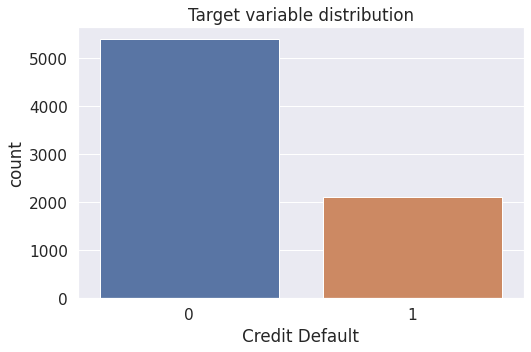

In [509]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()

(0 - погашен вовремя, 1 - просрочка)

**Корреляция с базовыми признаками**

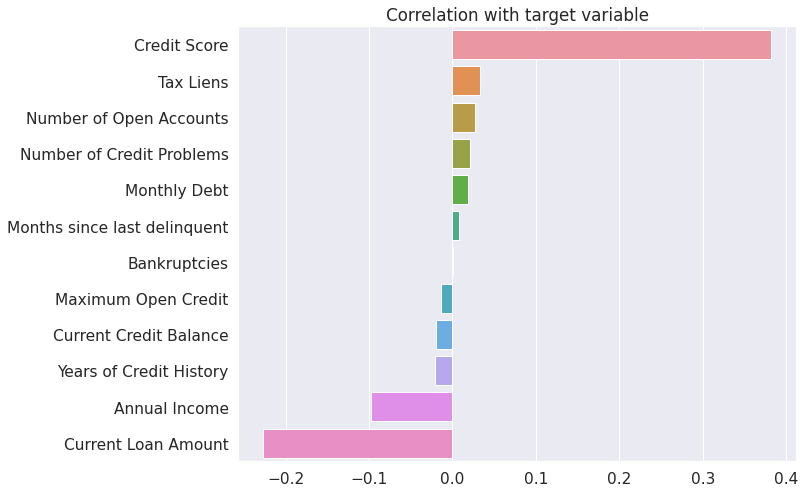

In [510]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

По графику видно, что больше всего влияют: Credit Score, Annual Income, Current Loan Amount. Но можно рассмотреть и 
    Tax Liens, Number of Open Accounts, Number of Credit Problems    

**Оценка признака "Credit Score" в разрезе целевой переменной**

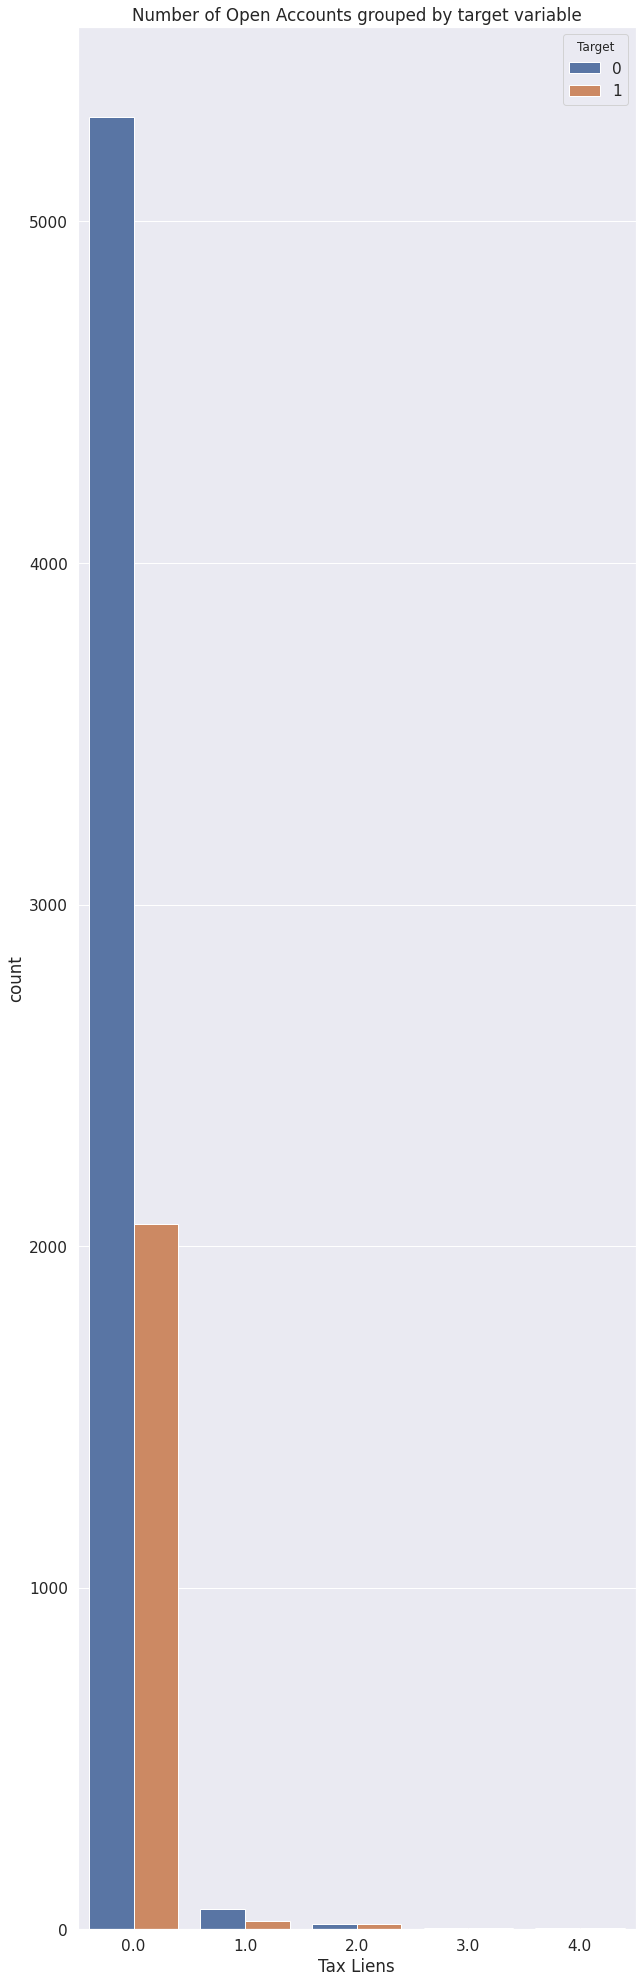

In [511]:
plt.figure(figsize=(10, 35))

sns.countplot(x="Tax Liens", hue=TARGET_NAME, data=df)
plt.title('Number of Open Accounts grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

**Наблюдение**

Изучив получившийся график, видно, что значения 2, 3, 4 признака "Tax Liens" имеют схожие доли в разрезе целевой переменной. Если это действительно так, то можно будет объединить их в одну категорию.

**Гипотеза** 

* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Для проверки данной гипотезы необходимо подать наблюдаемые частоты категорий 2, 3, 4 признака "Tax Liens" в выбранный критерий, после чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа, если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

*Сформируем выборку и рассчитаем наблюдаемые частоты*

In [0]:
TaxL_and_target_s = df.loc[df['Tax Liens'] > 1.0, ['ID', 'Tax Liens', 'Credit Default']]

In [513]:
table = TaxL_and_target_s.pivot_table(values='ID', index='Tax Liens', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Tax Liens,,
2.0,15,15
3.0,5,5
4.0,3,3


In [514]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

1.0

Гипотеза верна, и можно допустить, что категории 2, 3, 4 одинаково влияют на целевую переменную и их можно объединить в одну категорию. 

In [0]:
df.loc[df['Tax Liens'] == 3.0, 'Tax Liens'] = 2.0
df.loc[df['Tax Liens'] == 4.0, 'Tax Liens'] = 2.0

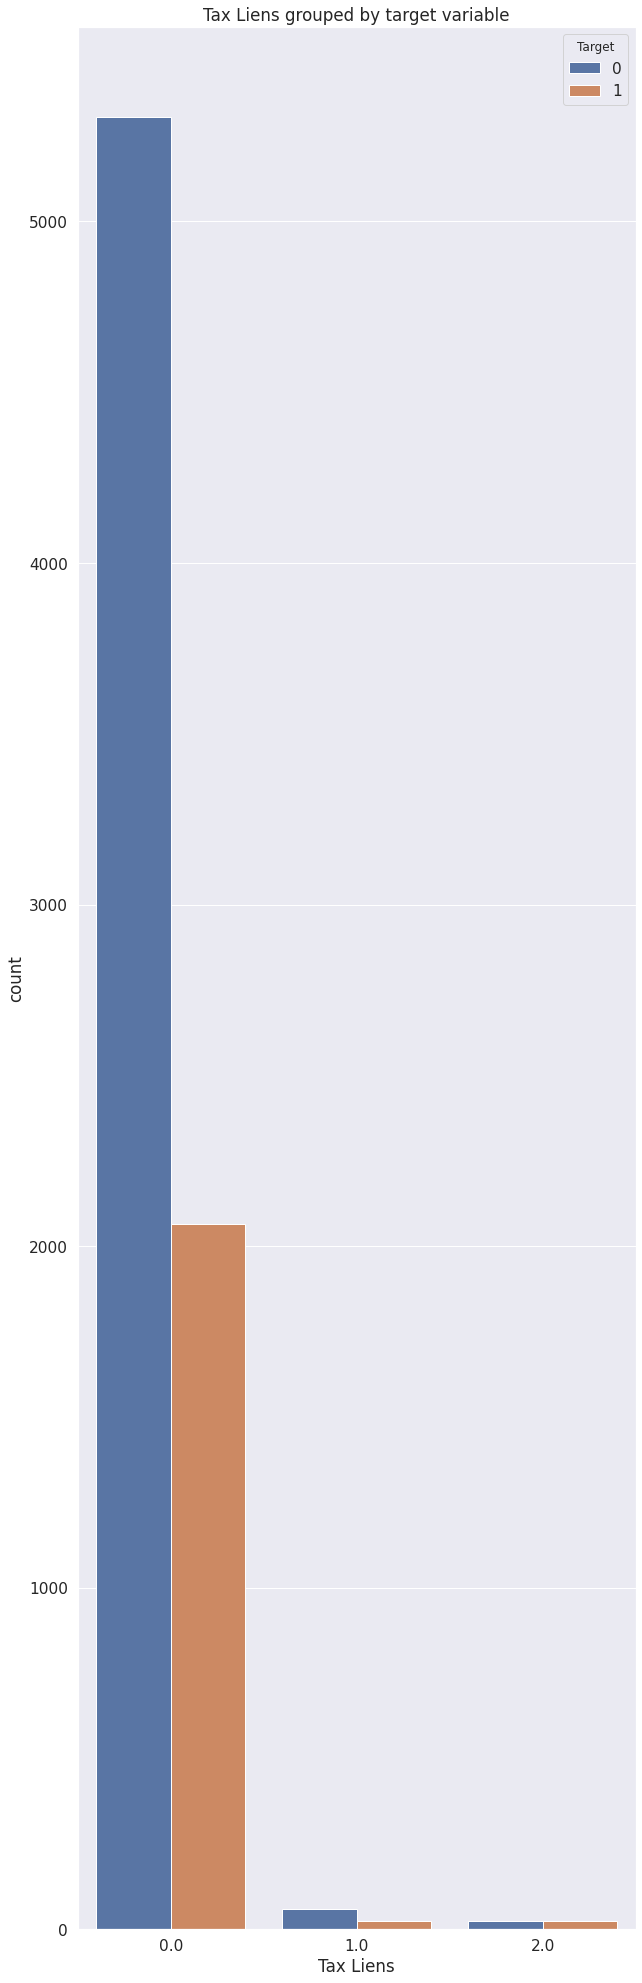

In [516]:
plt.figure(figsize=(10, 35))

sns.countplot(x="Tax Liens", hue=TARGET_NAME, data=df)
plt.title('Tax Liens grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Гипотеза 2 

0 и 1 можно объединить

In [0]:
TaxL_and_target_s = df.loc[df['Tax Liens'] < 2, ['ID', 'Tax Liens', 'Credit Default']]

In [518]:
table = TaxL_and_target_s.pivot_table(values='ID', index='Tax Liens', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Tax Liens,,
0.0,5305,2066
1.0,59,24


In [519]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.8580342176294803

Гипотеза 2 верна, и можно допустить, что категории 0, 1 одинаково влияют на целевую переменную и их можно объединить в одну категорию. 

In [0]:
df.loc[df['Tax Liens'] == 1.0, 'Tax Liens'] = 0.0

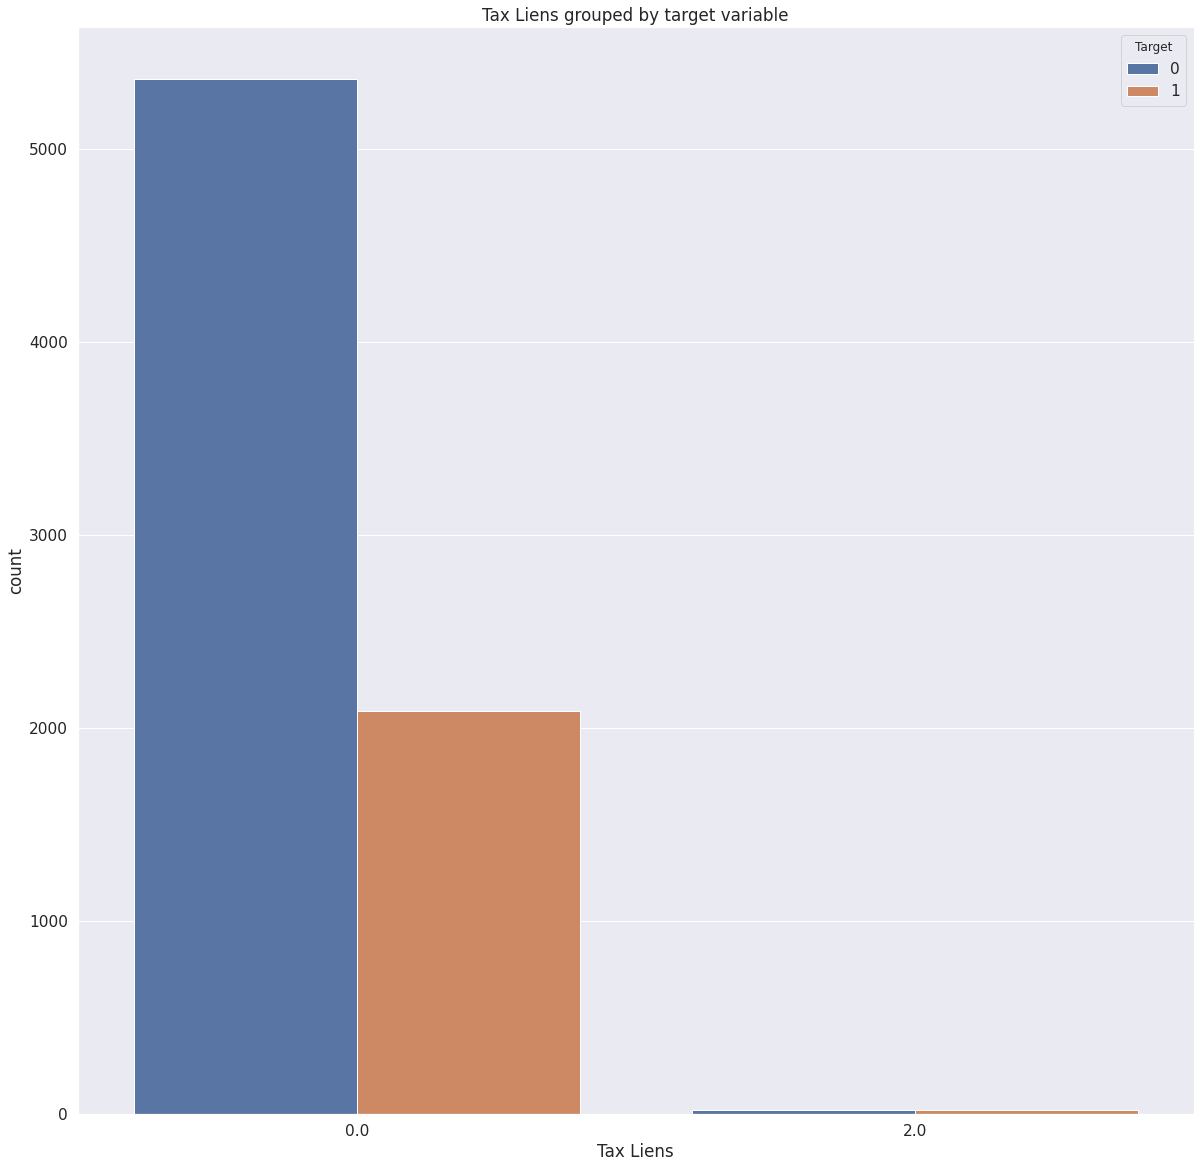

In [521]:
plt.figure(figsize=(20, 20))

sns.countplot(x="Tax Liens", hue=TARGET_NAME, data=df)
plt.title('Tax Liens grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

**Оценка признака "Annual Income" в разрезе целевой переменной**

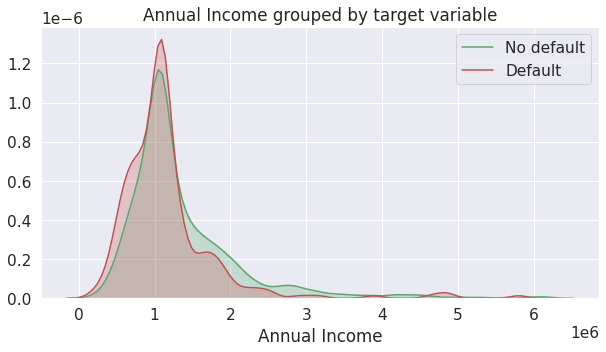

In [522]:
limit_bal_with_target_s = df[['Annual Income', TARGET_NAME]].sample(1000)
limit_bal_s = limit_bal_with_target_s['Annual Income']
limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 0]
limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(limit_bal_target_0, shade=True, label='No default', color='g')
sns.kdeplot(limit_bal_target_1, shade=True, label='Default', color='r')

plt.xlabel('Annual Income')
plt.title('Annual Income grouped by target variable')
plt.show()

**Наблюдение**

Похоже что две группы, полученные в результате разбиения признака "Annual Income" по целевой переменной, имеют различные распределения, что может помочь при построение модели, т.к. это будет означать, что между признаком "Annual Income" и целевой переменной, возможно, существует некоторая функциональная зависимость.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест) и его аналоги
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Что бы проверить данную гипотезу сравним две выборки из рассматриваемых групп на предмет равенства средних значений.
Если вероятность того, что мат. ожидания в исходных группах равны, при данных выборках, будет менее 5%, то можно будет говорить о том, что скорее всего выборки имеют различные распределения.

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка*

In [523]:
shapiro(limit_bal_s)

(0.7583115100860596, 7.148979398702091e-36)

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

**Оценка признака "Current Loan Amount" в разрезе целевой переменной**

In [0]:
# plt.figure(figsize=(20, 30))

# sns.countplot(x="Current Loan Amount", hue=TARGET_NAME, data=df)
# plt.title('Current Loan Amount grouped by target variable')
# plt.legend(title='Target', loc='upper right')

# plt.show()

**Матрица корреляций**

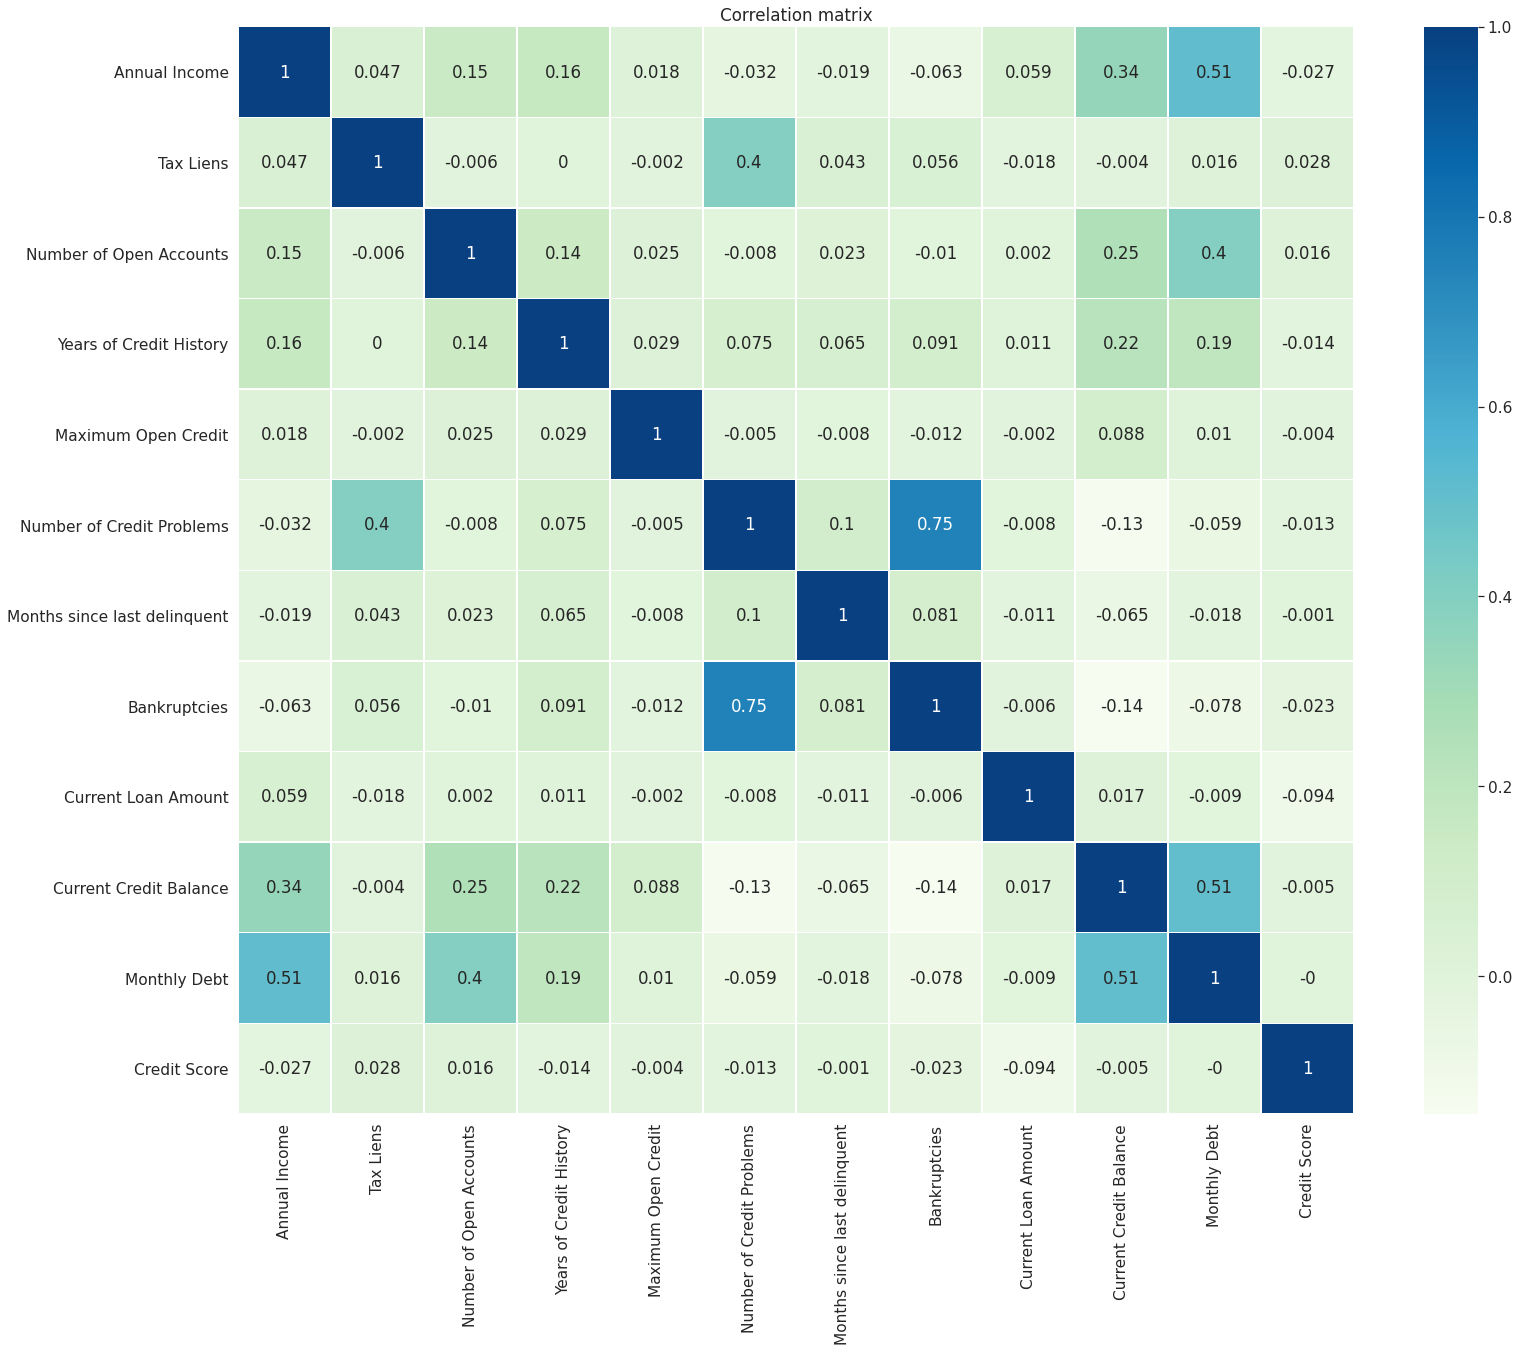

In [525]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

**Оценка признака "Number of Open Accounts" в разрезе целевой переменной**

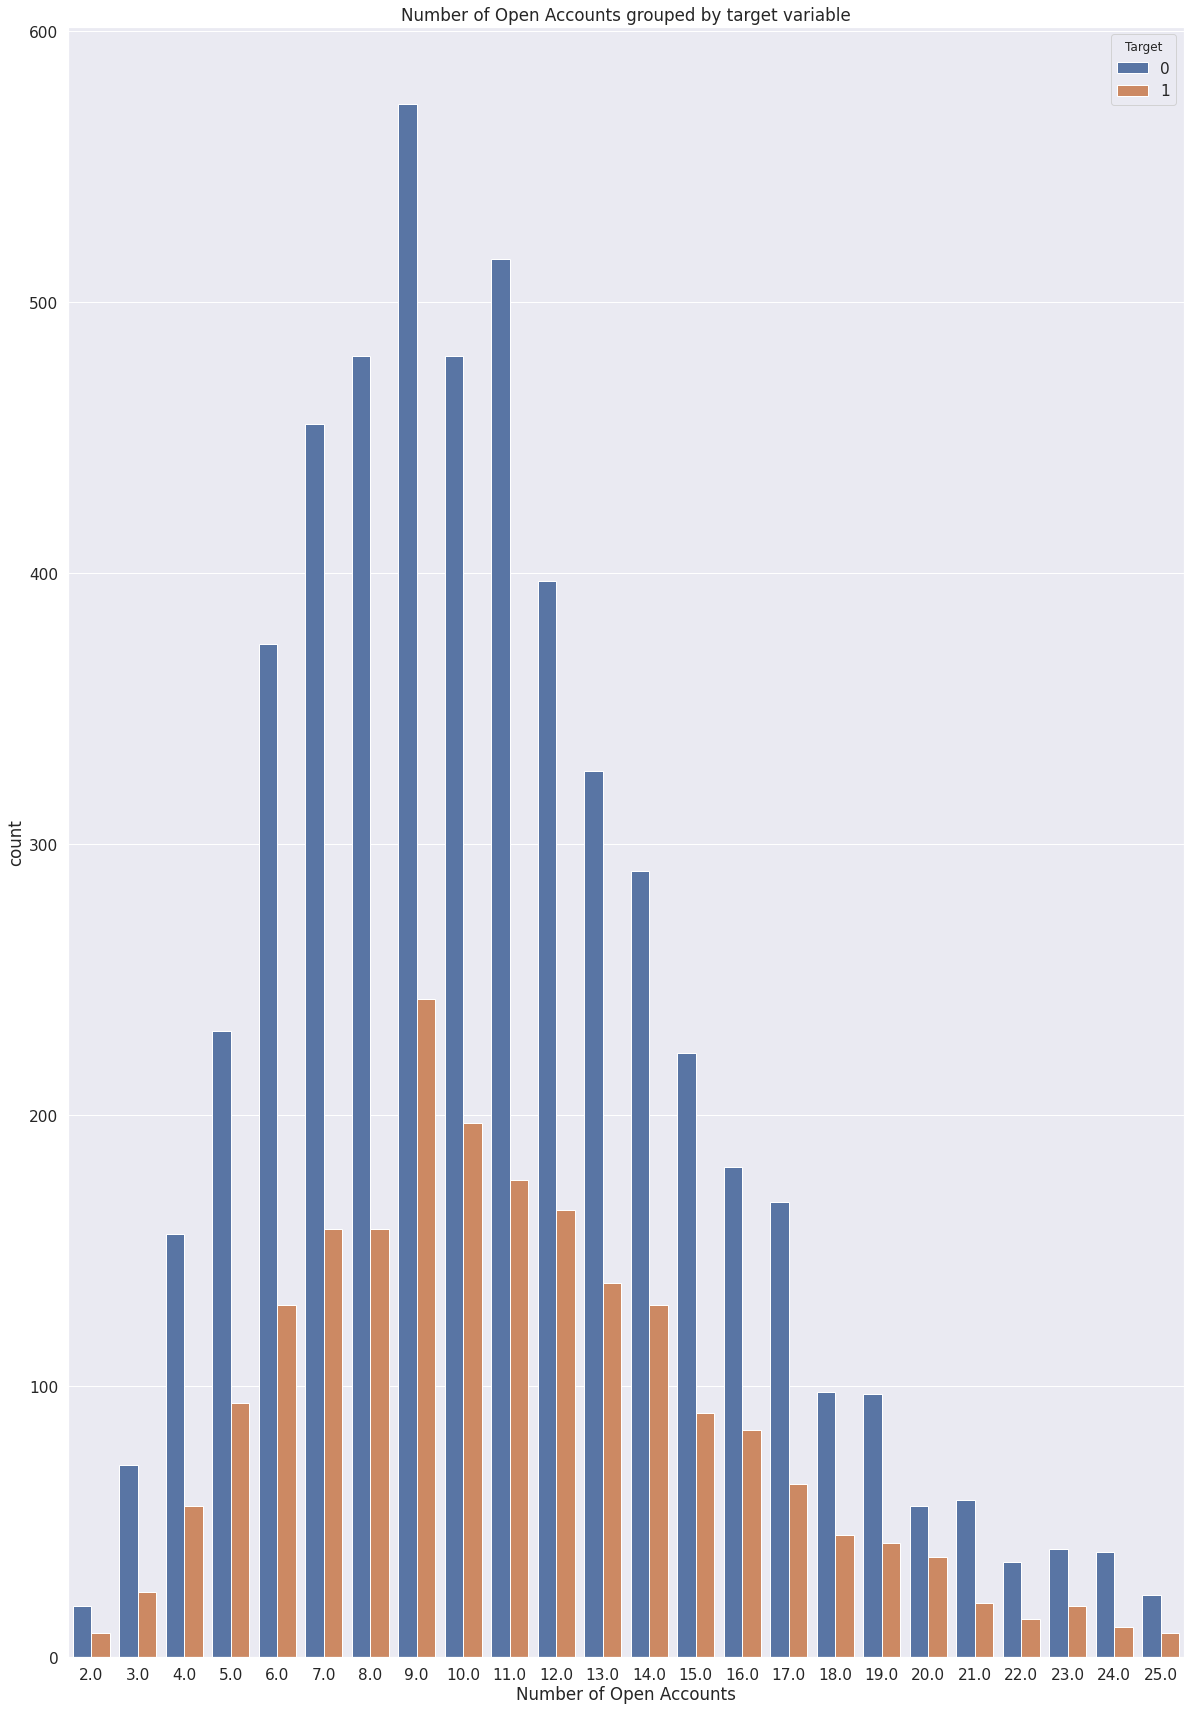

In [526]:
plt.figure(figsize=(20, 30))

sns.countplot(x="Number of Open Accounts", hue=TARGET_NAME, data=df)
plt.title('Number of Open Accounts grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Гипотеза 1:

можно объединить [2:17]

In [0]:
NOA_and_target_s = df.loc[(df['Number of Open Accounts'] < 18 ) & (df['Number of Open Accounts'] > 1)  , ['ID', 'Number of Open Accounts', 'Credit Default']]

In [528]:
table = NOA_and_target_s.pivot_table(values='ID', index='Number of Open Accounts', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Number of Open Accounts,,
2.0,19,9
3.0,71,24
4.0,156,56
5.0,231,94
6.0,374,130
7.0,455,158
8.0,480,158
9.0,573,243
10.0,480,197


In [529]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.3907390795101371

Гипотеза1 верна, и можно допустить, что категории [2:17] одинаково влияют на целевую переменную и их можно объединить в одну категорию. 

In [0]:
df.loc[(df['Number of Open Accounts'] < 18 ) & (df['Number of Open Accounts'] > 2), 'Number of Open Accounts'] = 1.0


Гипотеза 2:

можно объединить 18,19

In [0]:
NOA_and_target_s = df.loc[(df['Number of Open Accounts'] == 18 ) | (df['Number of Open Accounts'] == 19)  , ['ID', 'Number of Open Accounts', 'Credit Default']]

In [532]:
table = NOA_and_target_s.pivot_table(values='ID', index='Number of Open Accounts', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Number of Open Accounts,,
18.0,98,45
19.0,97,42


In [533]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.8198759995306371

Гипотеза2 верна, и можно допустить, что категории 18 и 19 одинаково влияют на целевую переменную и их можно объединить в одну категорию. 

In [0]:
df.loc[(df['Number of Open Accounts'] == 18 ) | (df['Number of Open Accounts'] == 19), 'Number of Open Accounts'] = 2.0


Гипотеза 3:

можно объединить 20,21

In [0]:
NOA_and_target_s = df.loc[(df['Number of Open Accounts'] == 20 ) | (df['Number of Open Accounts'] == 21)  , ['ID', 'Number of Open Accounts', 'Credit Default']]

In [536]:
table = NOA_and_target_s.pivot_table(values='ID', index='Number of Open Accounts', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Number of Open Accounts,,
20.0,56,37
21.0,58,20


In [537]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.05067875136035667

Гипотеза 3 верна, и можно допустить, что категории 20 и 21 одинаково влияют на целевую переменную и их можно объединить в одну категорию. 

In [0]:
df.loc[(df['Number of Open Accounts'] == 20 ) | (df['Number of Open Accounts'] == 21), 'Number of Open Accounts'] = 3.0


Гипотеза 4:

можно объединить [22:25]

In [0]:
NOA_and_target_s = df.loc[(df['Number of Open Accounts'] < 26 ) & (df['Number of Open Accounts'] > 21)  , ['ID', 'Number of Open Accounts', 'Credit Default']]

In [540]:
table = NOA_and_target_s.pivot_table(values='ID', index='Number of Open Accounts', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Number of Open Accounts,,
22.0,35,14
23.0,40,19
24.0,39,11
25.0,23,9


In [541]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.7007711212555487

Гипотеза 4 верна, и можно допустить, что категории [22:25] одинаково влияют на целевую переменную и их можно объединить в одну категорию. 

In [0]:
df.loc[(df['Number of Open Accounts'] < 26 ) & (df['Number of Open Accounts'] > 21), 'Number of Open Accounts'] = 4.0


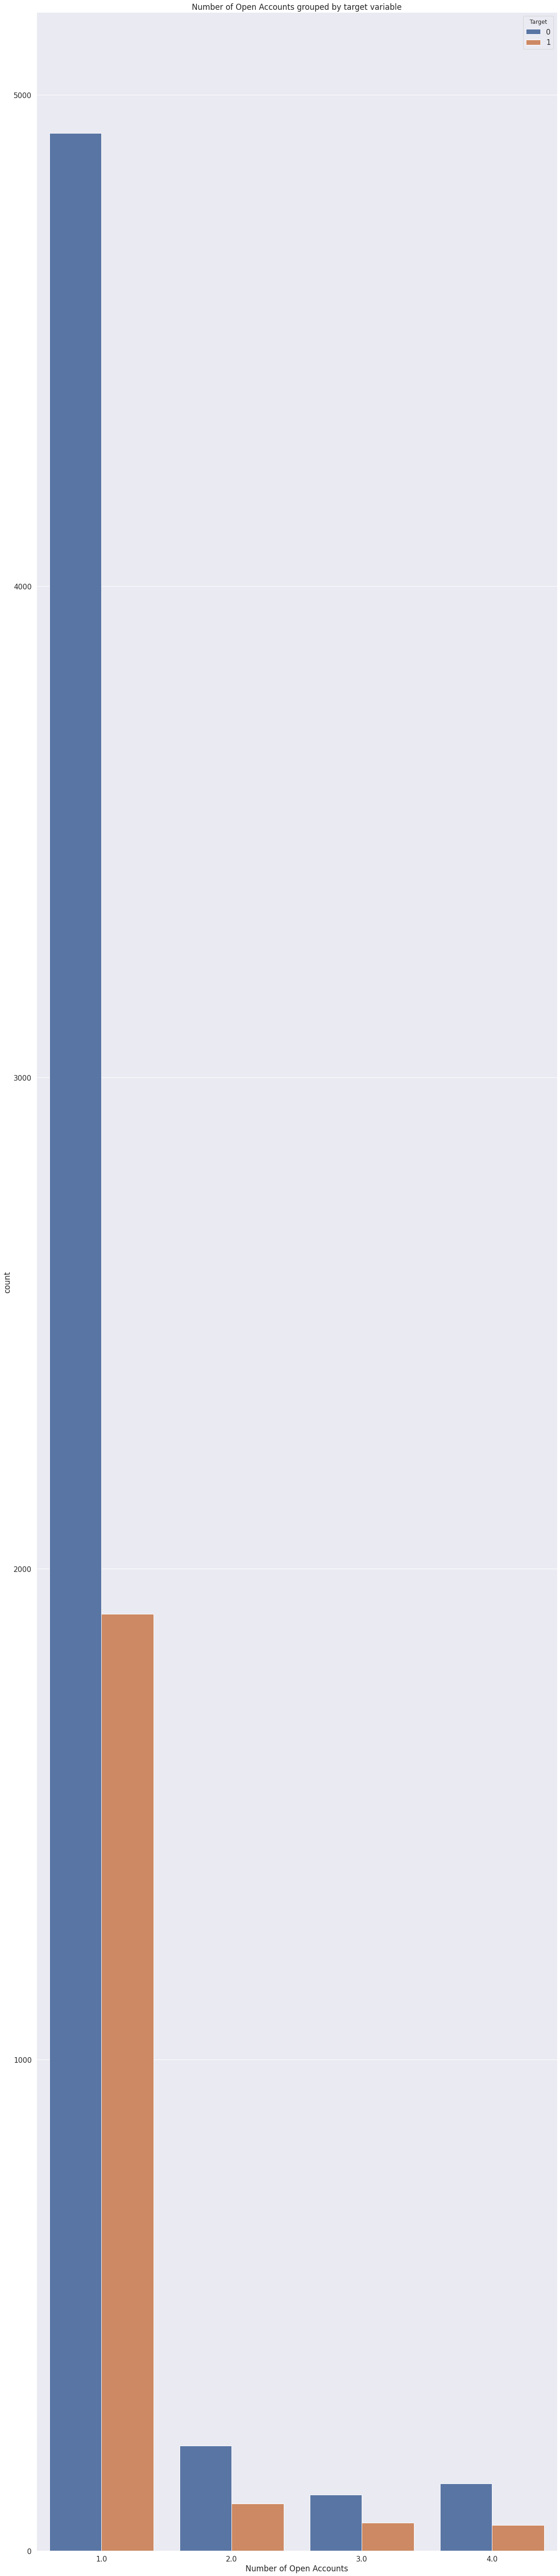

In [543]:
plt.figure(figsize=(20, 100))

sns.countplot(x="Number of Open Accounts", hue=TARGET_NAME, data=df)
plt.title('Number of Open Accounts grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

**Оценка признака "Number of Credit Problems" в разрезе целевой переменной**

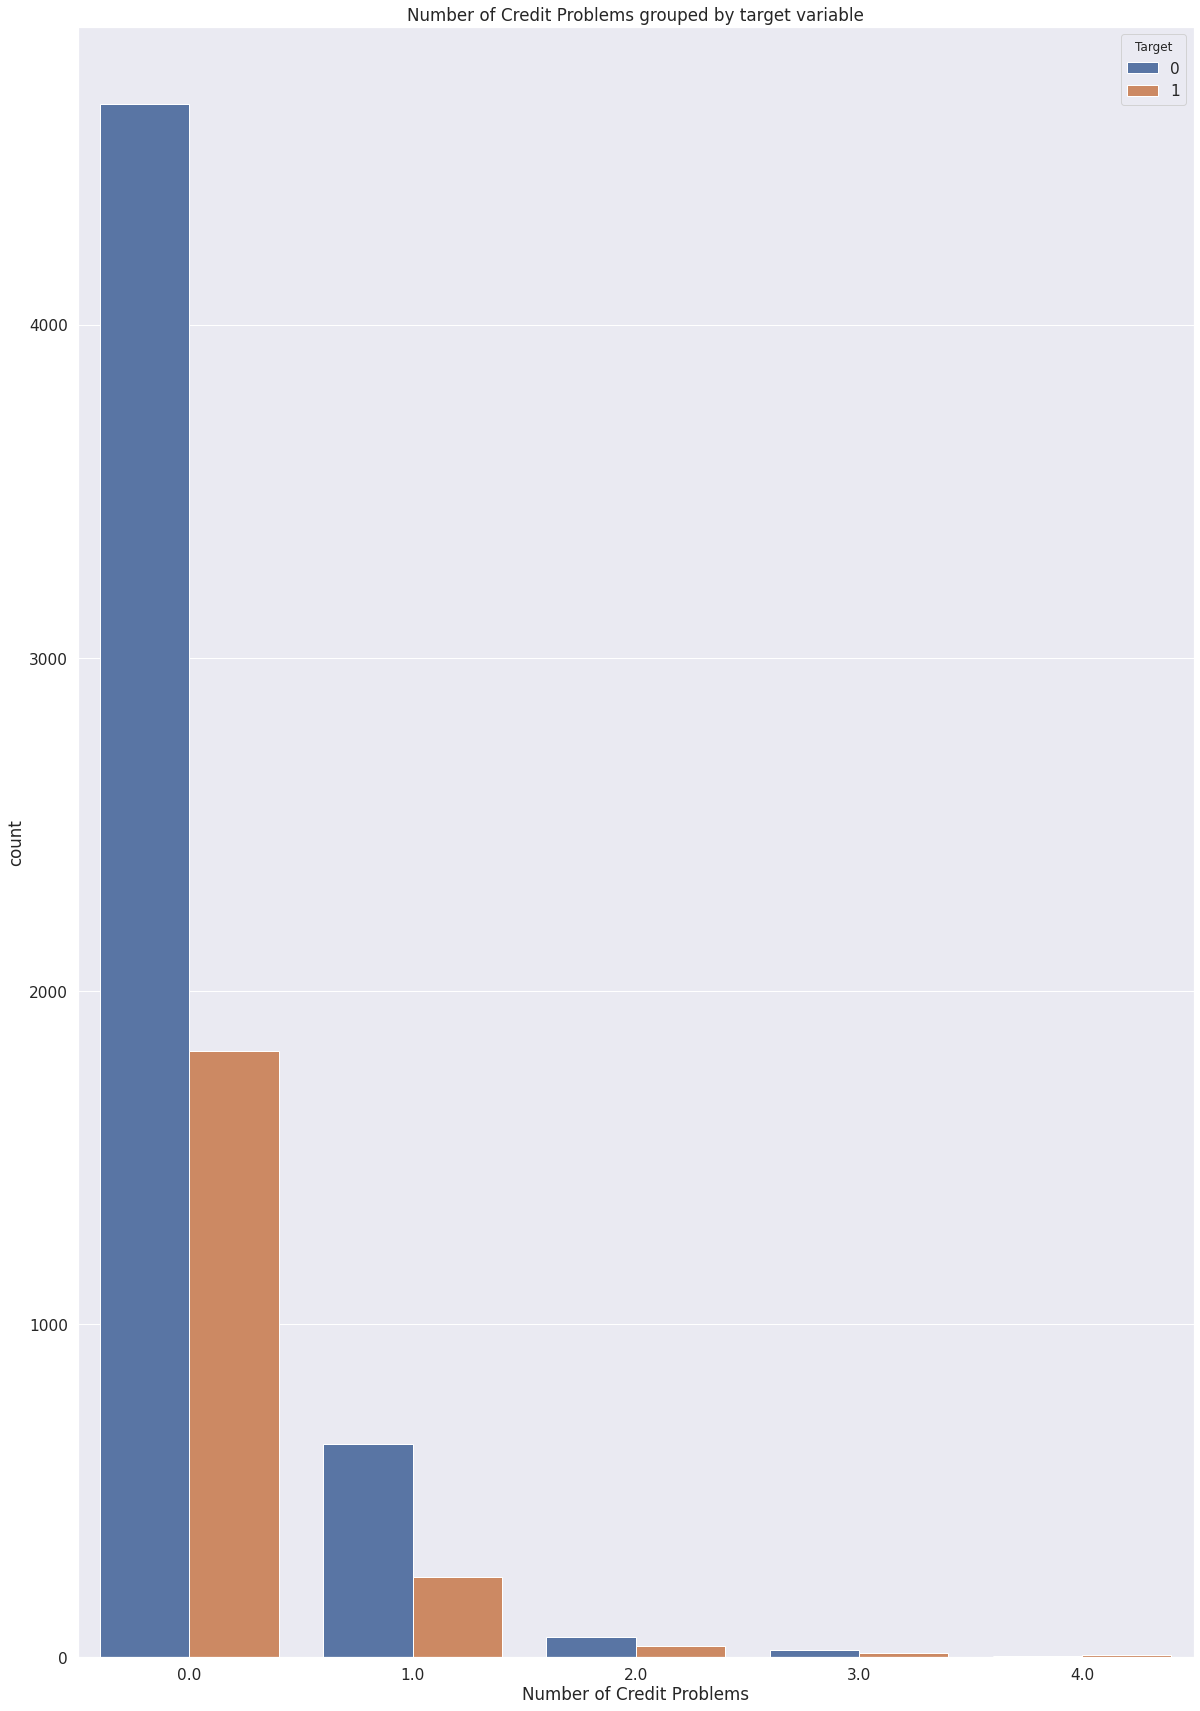

In [544]:
plt.figure(figsize=(20, 30))

sns.countplot(x="Number of Credit Problems", hue=TARGET_NAME, data=df)
plt.title('Number of Credit Problems grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Гипотеза 1:

можно объединить 0 и 1

In [0]:
NOA_and_target_s = df.loc[(df['Number of Credit Problems'] == 0.0 ) | (df['Number of Credit Problems'] == 1.0)  , ['ID', 'Number of Credit Problems', 'Credit Default']]

In [546]:
table = NOA_and_target_s.pivot_table(values='ID', index='Number of Credit Problems', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Number of Credit Problems,,
0.0,4662,1819
1.0,641,241


In [547]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.6449345818546169

Гипотеза 1 верна, и можно допустить, что категории 0 и 1 одинаково влияют на целевую переменную и их можно объединить в одну категорию. 

In [0]:
df.loc[(df['Number of Credit Problems'] == 0.0 )| (df['Number of Credit Problems'] == 1.0), 'Number of Credit Problems'] = 1.0


Гипотеза 2:

можно объединить 2 и 3

In [0]:
NOA_and_target_s = df.loc[(df['Number of Credit Problems'] == 2.0 ) | (df['Number of Credit Problems'] == 3.0)  , ['ID', 'Number of Credit Problems', 'Credit Default']]

In [550]:
table = NOA_and_target_s.pivot_table(values='ID', index='Number of Credit Problems', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Number of Credit Problems,,
2.0,60,33
3.0,21,14


In [551]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.6366059864241481

Гипотеза 2 верна, и можно допустить, что категории [26:34] одинаково влияют на целевую переменную и их можно объединить в одну категорию. 

In [0]:
df.loc[(df['Number of Credit Problems'] == 2.0 )| (df['Number of Credit Problems'] == 3.0), 'Number of Credit Problems'] = 2.0


Гипотеза 3:

можно объединить 4 и 5

In [0]:
NOA_and_target_s = df.loc[(df['Number of Credit Problems'] == 4 ) | (df['Number of Credit Problems'] == 5)  , ['ID', 'Number of Credit Problems', 'Credit Default']]

In [554]:
table = NOA_and_target_s.pivot_table(values='ID', index='Number of Credit Problems', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Number of Credit Problems,,
4.0,3,6


In [555]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

1.0

Гипотеза 3 верна, и можно допустить, что категории [26:34] одинаково влияют на целевую переменную и их можно объединить в одну категорию. 

In [0]:
df.loc[(df['Number of Credit Problems'] == 4.0 )| (df['Number of Credit Problems'] == 5.0), 'Number of Credit Problems'] = 3.0


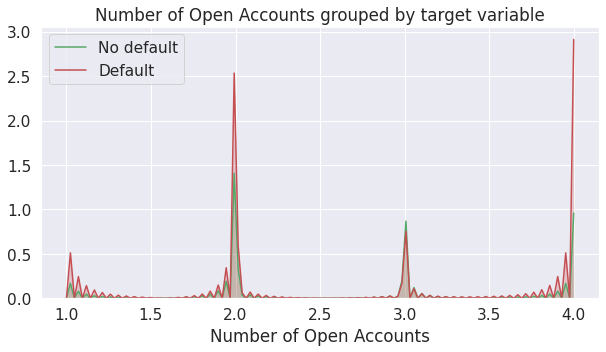

In [557]:
limit_bal_with_target_s = df[['Number of Open Accounts', TARGET_NAME]].sample(1000)
limit_bal_s = limit_bal_with_target_s['Number of Open Accounts']
limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 0]
limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(limit_bal_target_0, shade=True, label='No default', color='g')
sns.kdeplot(limit_bal_target_1, shade=True, label='Default', color='r')

plt.xlabel('Number of Open Accounts')
plt.title('Number of Open Accounts grouped by target variable')
plt.show()

In [558]:
shapiro(limit_bal_s)

(0.297260046005249, 0.0)

Создадим новую фичу "Average amount on 1 account" = "Credit Score"/"Number of Open Accounts"

In [0]:
df['Average amount on 1 account'] = df['Credit Score']/df['Number of Open Accounts']

In [560]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,ID,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_< 1 year,Tax Liens_0.0,Tax Liens_1.0,Tax Liens_2.0,Tax Liens_3.0,Tax Liens_4.0,Number of Open Accounts_10.0,Number of Open Accounts_11.0,Number of Open Accounts_12.0,Number of Open Accounts_13.0,Number of Open Accounts_14.0,Number of Open Accounts_15.0,...,Number of Open Accounts_20.0,Number of Open Accounts_21.0,Number of Open Accounts_22.0,Number of Open Accounts_23.0,Number of Open Accounts_24.0,Number of Open Accounts_25.0,Number of Open Accounts_3.0,Number of Open Accounts_4.0,Number of Open Accounts_5.0,Number of Open Accounts_6.0,Number of Open Accounts_7.0,Number of Open Accounts_8.0,Number of Open Accounts_9.0,Number of Credit Problems_0.0,Number of Credit Problems_1.0,Number of Credit Problems_2.0,Number of Credit Problems_3.0,Number of Credit Problems_4.0,Bankruptcies_0.0,Bankruptcies_1.0,Bankruptcies_2.0,Bankruptcies_nan,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term,Average amount on 1 account
0,Own Home,482087.0,10+ years,0.0,1.0,26.3,685960.0,1.0,15.8152,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,749.0
1,Own Home,1025487.0,10+ years,0.0,1.0,15.3,1181730.0,1.0,15.8152,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,737.0
2,Home Mortgage,751412.0,8 years,0.0,1.0,35.0,1182434.0,1.0,15.8152,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0,2,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,742.0
3,Own Home,805068.0,6 years,0.0,1.0,22.5,147400.0,1.0,15.8152,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,3,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,694.0
4,Rent,776264.0,8 years,0.0,1.0,13.6,385836.0,1.0,15.8152,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,4,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,719.0


**Оценка признака "Average amount on 1 account" в разрезе целевой переменной**

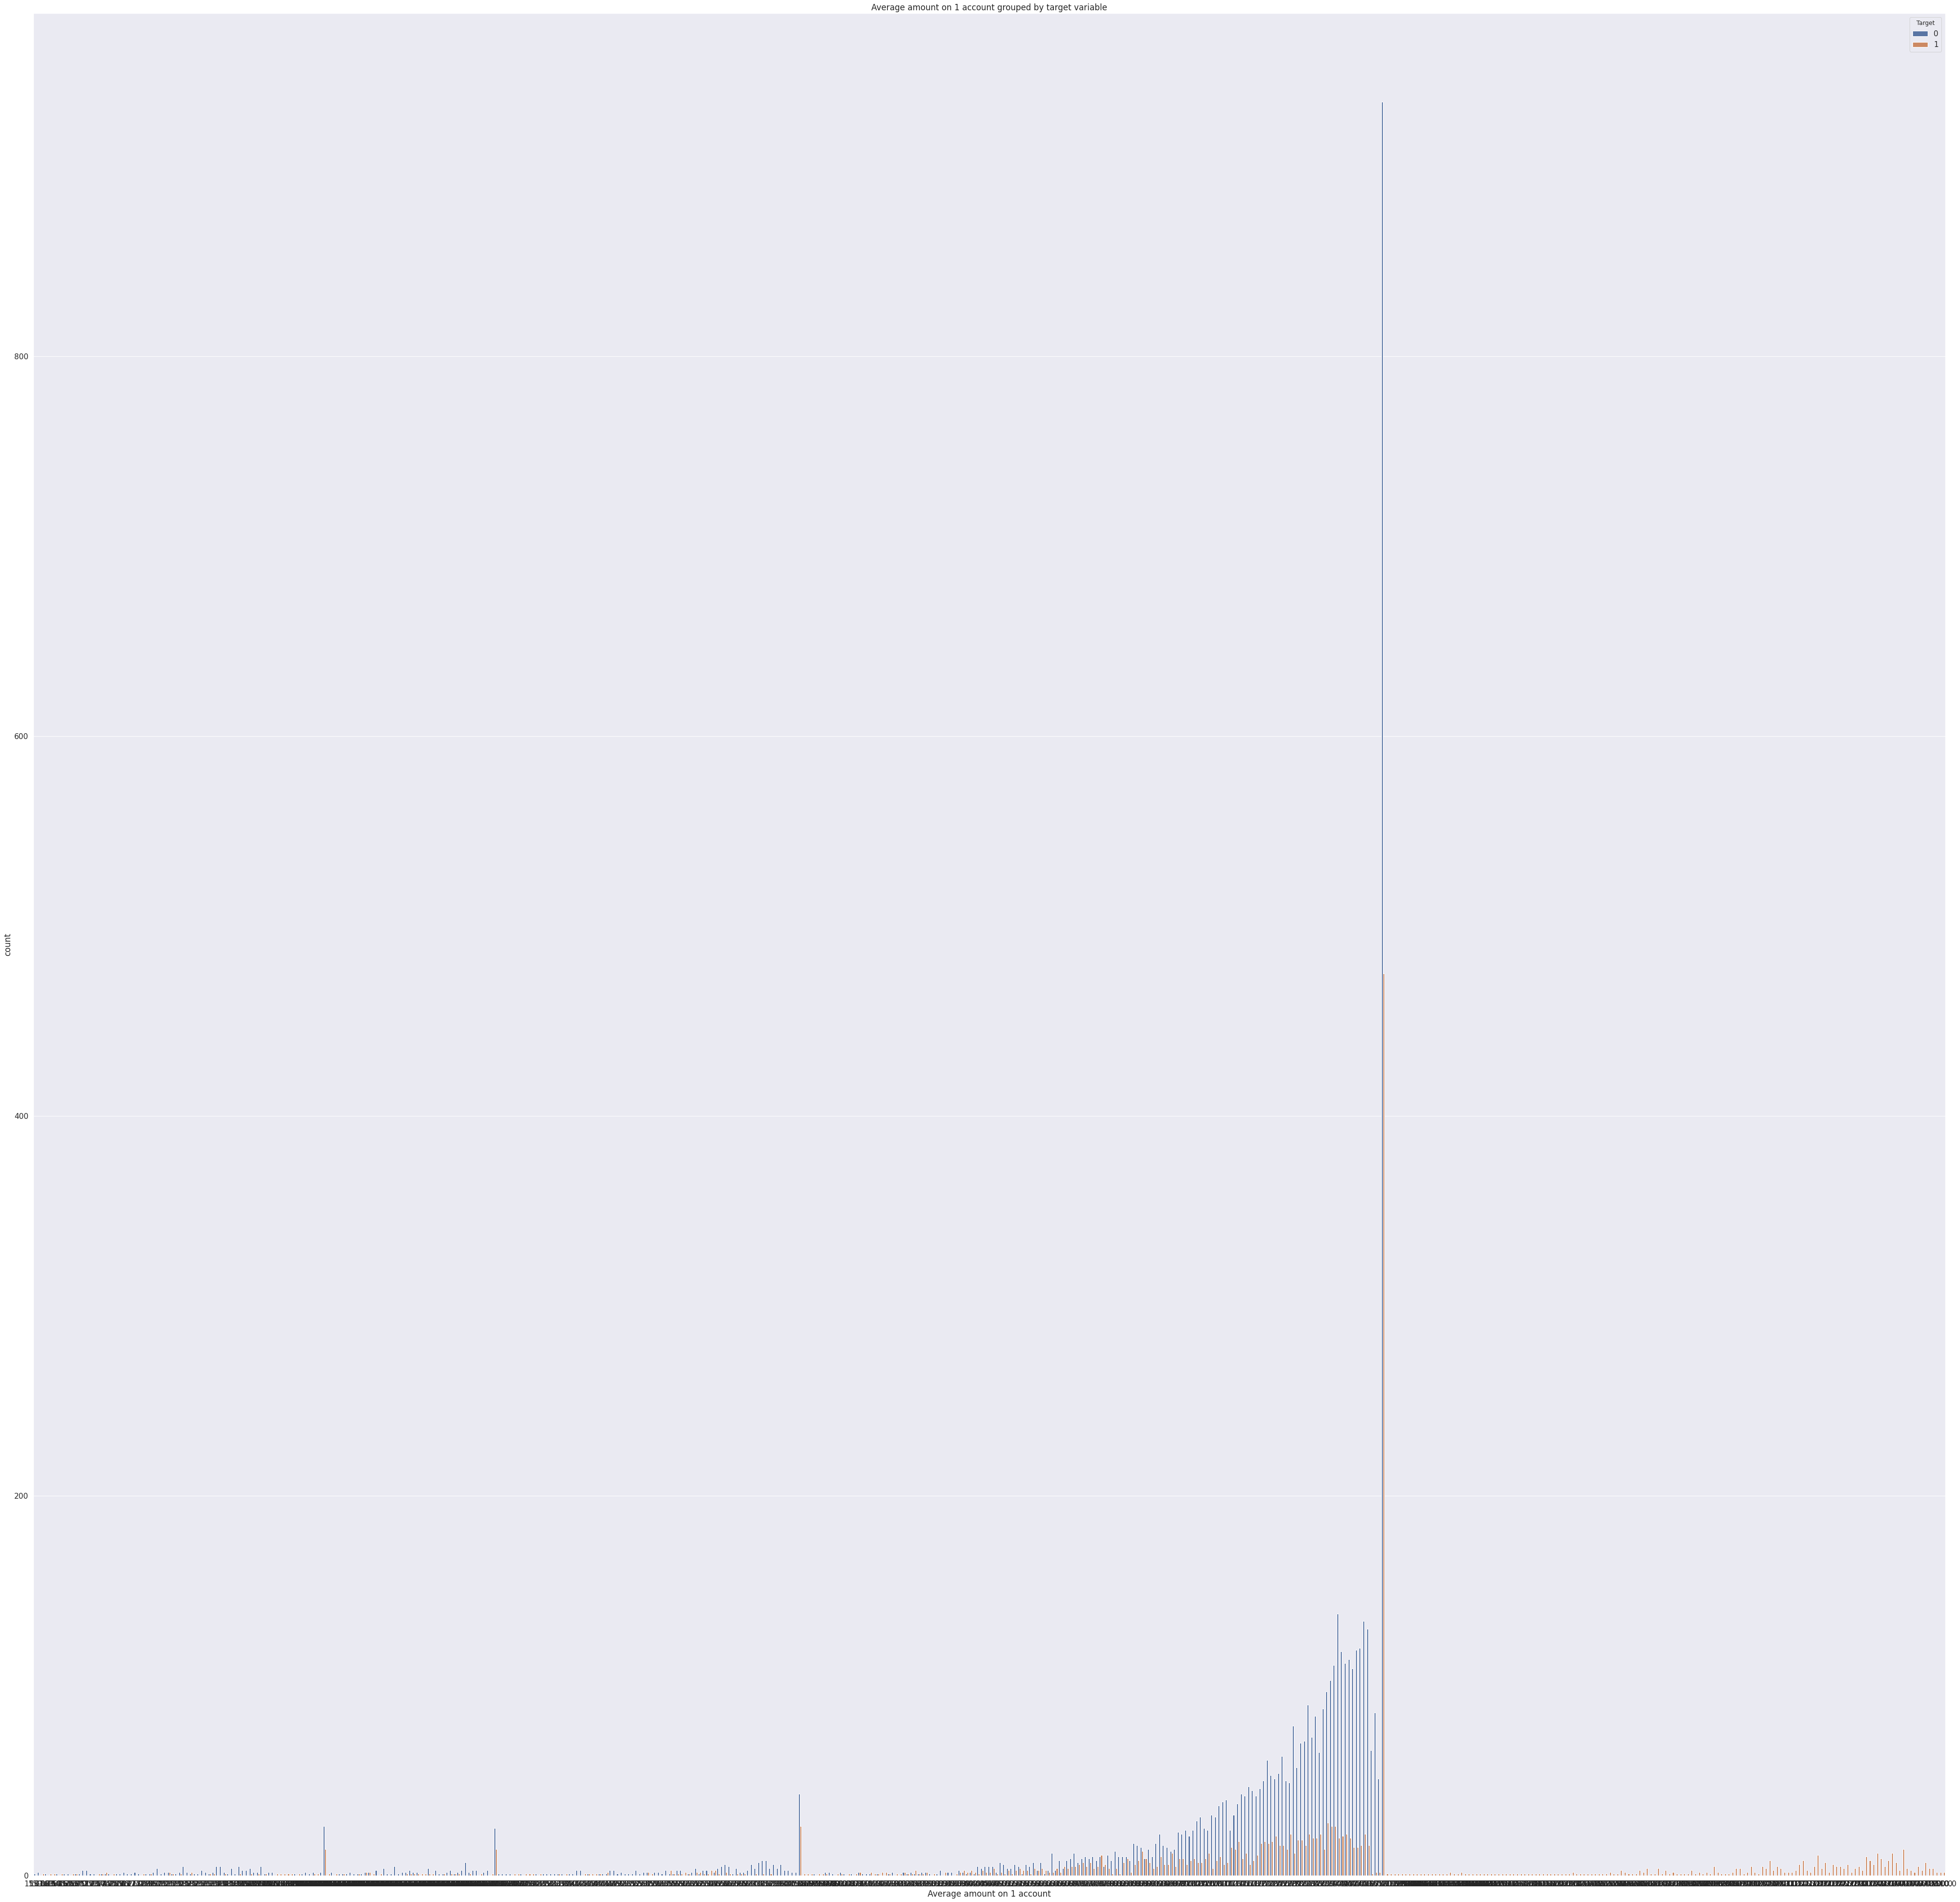

In [561]:
plt.figure(figsize=(70, 70))

sns.countplot(x="Average amount on 1 account", hue=TARGET_NAME, data=df)
plt.title('Average amount on 1 account grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [0]:
# min(df['Average amount on 1 account']),max(df['Average amount on 1 account'])

In [0]:
# df.fillna(0)

Гипотеза 1 верна, и можно допустить, что категории [117:500] одинаково влияют на целевую переменную и их можно объединить в одну категорию. 

In [0]:
# NOA_and_target_s = df.loc[(df['Average amount on 1 account'] > 117 ) & (df['Average amount on 1 account'] < 201)  , ['ID', 'Average amount on 1 account', 'Credit Default']]

In [0]:
# df['Average amount on 1 account'] = df['Average amount on 1 account'].fillna('0')
# df['Average amount on 1 account']=df['Average amount on 1 account'].replace(to_replace = np.nan, value = 0.0) 

In [0]:
# table = NOA_and_target_s.pivot_table(values='ID', index='Average amount on 1 account', columns='Credit Default', aggfunc='count')
# table

In [0]:
# limit_bal_with_target_s = df[['Average amount on 1 account', TARGET_NAME]].sample(1000)
# limit_bal_s = limit_bal_with_target_s['Average amount on 1 account']
# limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 0]
# limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 1]

# plt.figure(figsize=(10, 5))

# sns.kdeplot(limit_bal_target_0, shade=True, label='No default', color='g')
# sns.kdeplot(limit_bal_target_1, shade=True, label='Default', color='r')

# plt.xlabel('Number of Open Accounts')
# plt.title('Number of Open Accounts grouped by target variable')
# plt.show()

In [568]:
shapiro(limit_bal_s)

(0.297260046005249, 0.0)

**Оценка признака "Tax Liens" в разрезе целевой переменной**

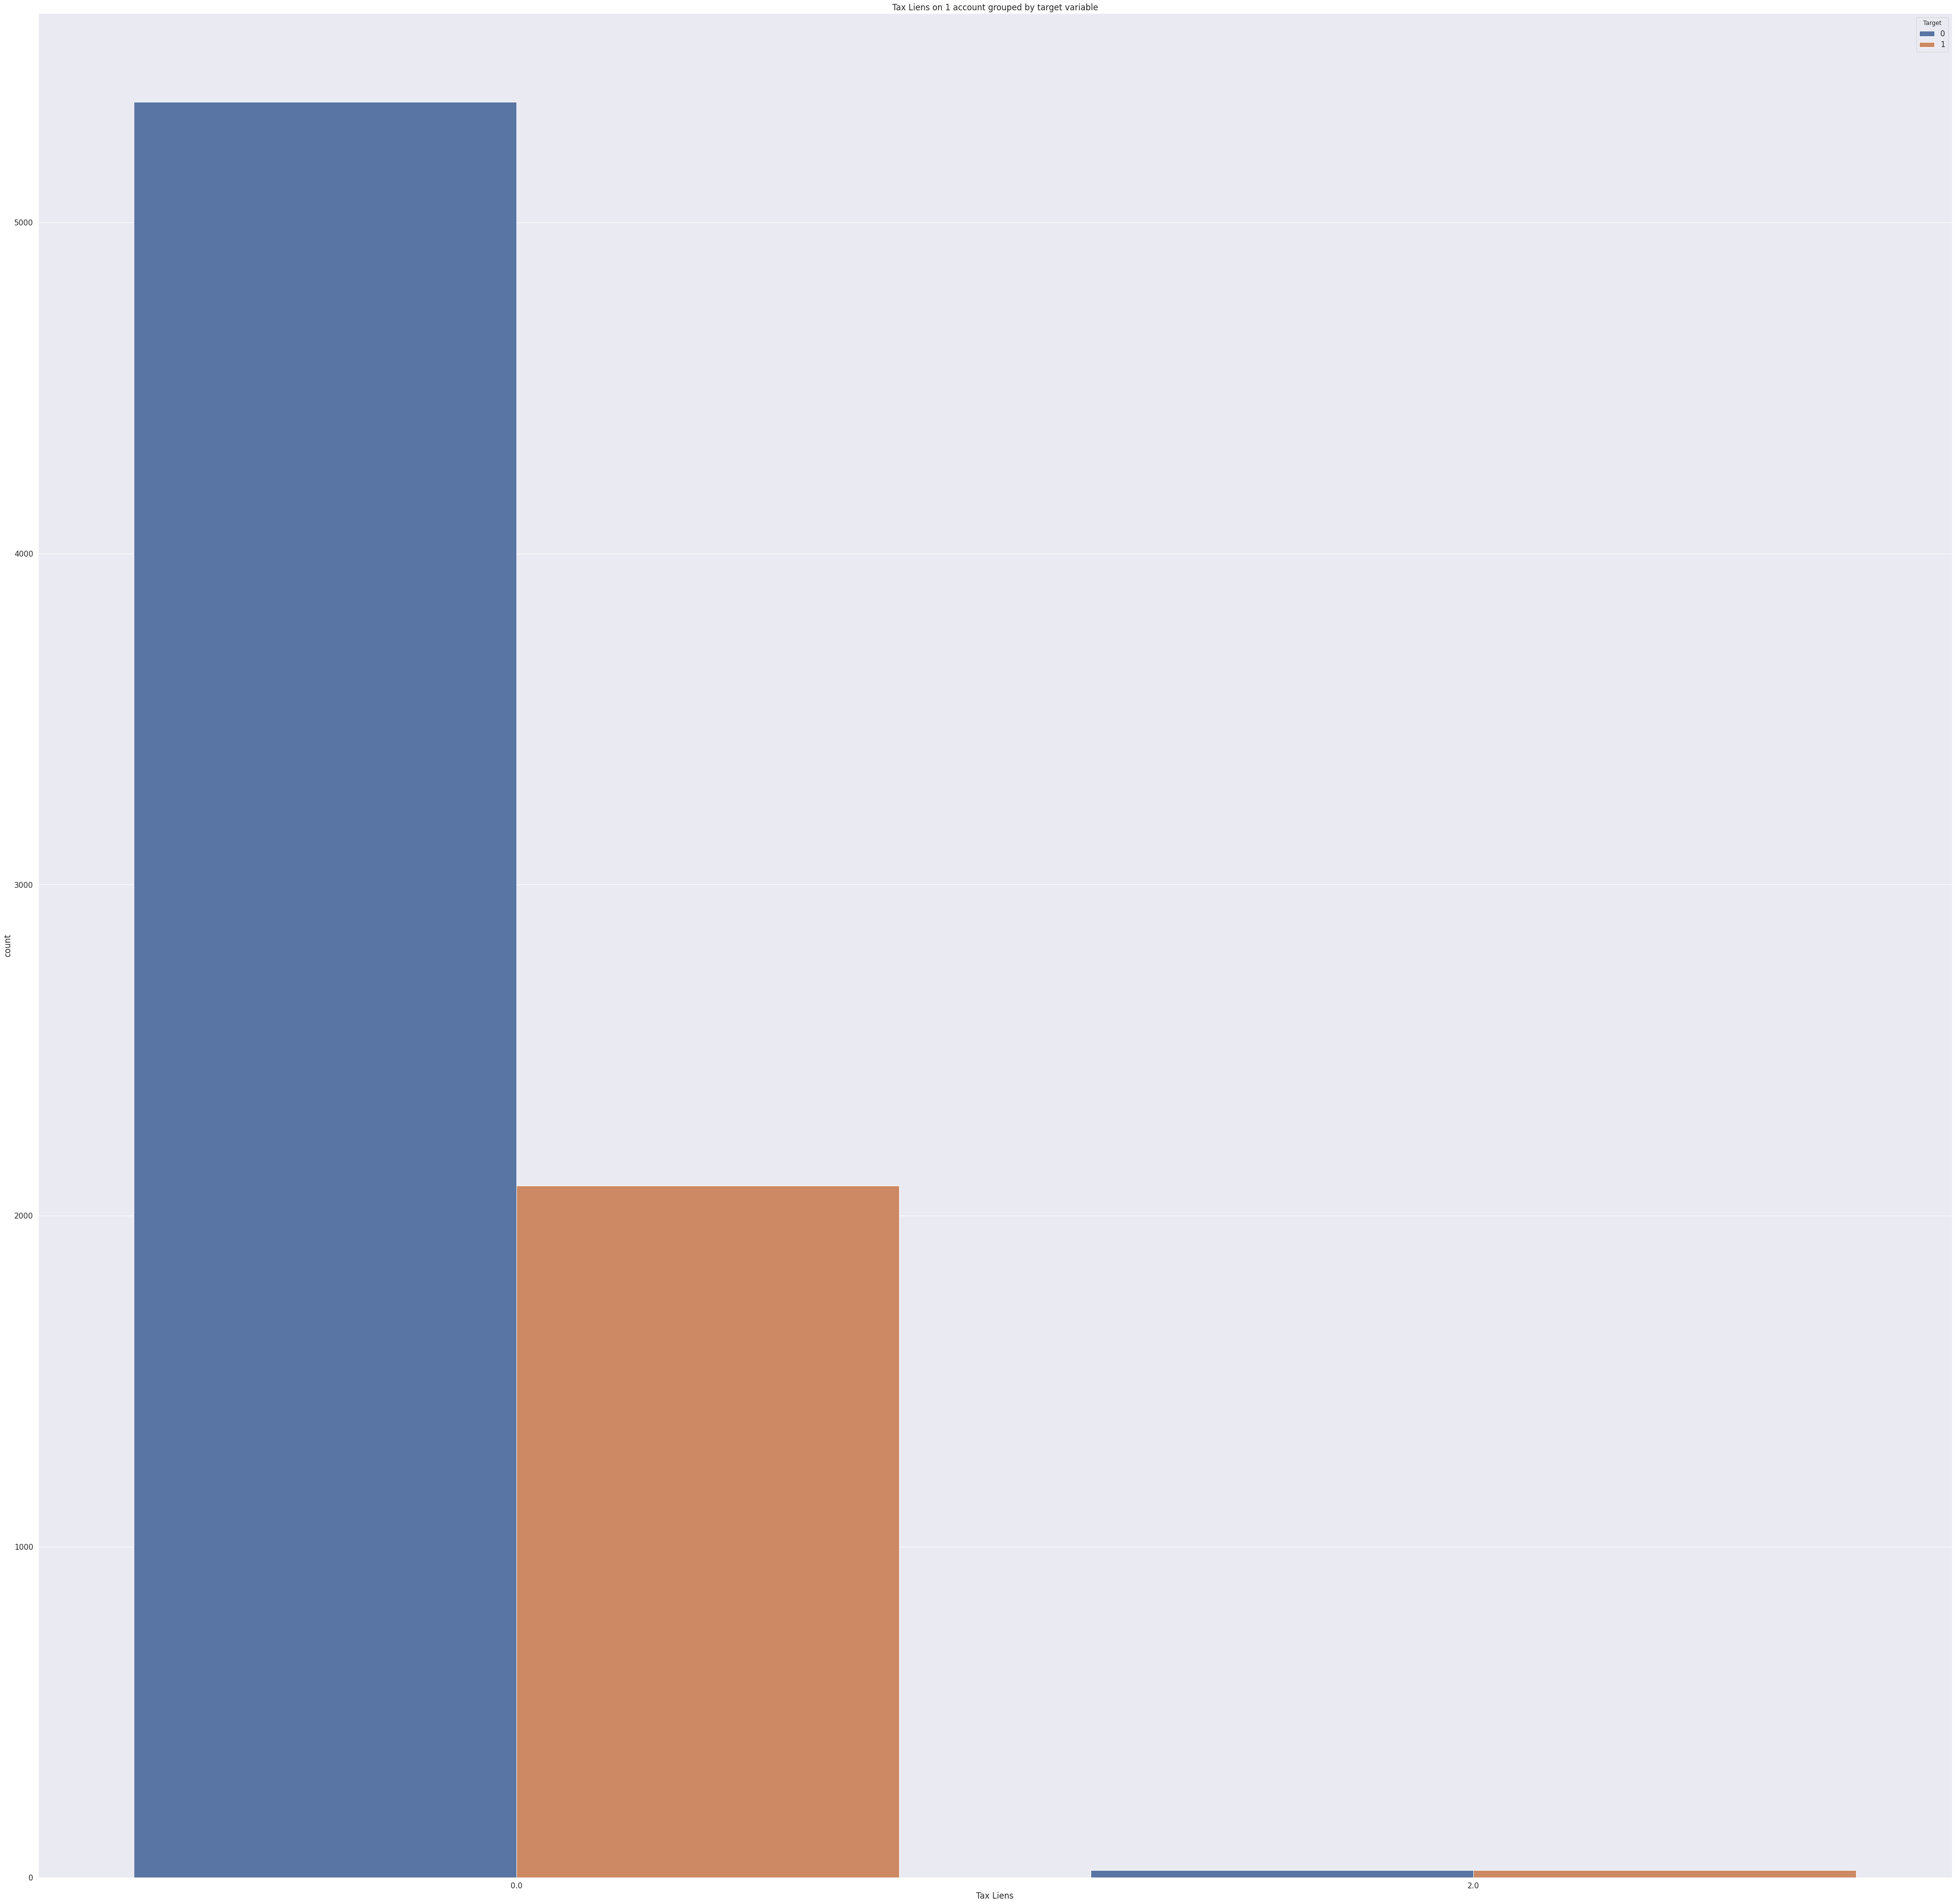

In [569]:
plt.figure(figsize=(70, 70))

sns.countplot(x="Tax Liens", hue=TARGET_NAME, data=df)
plt.title('Tax Liens on 1 account grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [570]:
len(df) - df.count()

Home Ownership                 0
Annual Income                  0
Years in current job           0
Tax Liens                      0
Number of Open Accounts        0
                              ..
Purpose_vacation               0
Purpose_wedding                0
Term_Long Term                 0
Term_Short Term                0
Average amount on 1 account    0
Length: 85, dtype: int64

In [0]:
df.to_csv('course_project_train_prep_2.csv', index=False, encoding='utf-8')